In [1]:
import uproot4
import numpy as np
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "GenVertex": ak.zip({
                                            "x": dq_dict["gvx"],
                                            "y": dq_dict["gvy"],
                                            "z": dq_dict["gvz"],
                                            "px": dq_dict["gpx"],
                                            "py": dq_dict["gpy"],
                                            "pz": dq_dict["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict["gpx_st1"],
                                            "py": dq_dict["gpy_st1"],
                                            "pz": dq_dict["gpz_st1"],
                                            "x":dq_dict["gx_st1"],
                                            "y":dq_dict["gy_st1"],
                                            "z":dq_dict["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict["track_px_st1"],
                                            "py": dq_dict["track_py_st1"],
                                            "pz": dq_dict["track_pz_st1"],
                                            "x":  dq_dict["track_x_st1"],
                                            "y":  dq_dict["track_y_st1"],
                                            "z":  dq_dict["track_z_st1"],
                        }),
                        
                       }, depth_limit=1)
    return dq_events


######## READ EVENTS
filename = "ntuples/ApMuons_May262021.root"
dq_events = getData(filename)

Saving plots to:  plot/27-05-2021


## Truth momentum distribution at vertex

Text(0, 1, 'Counts')

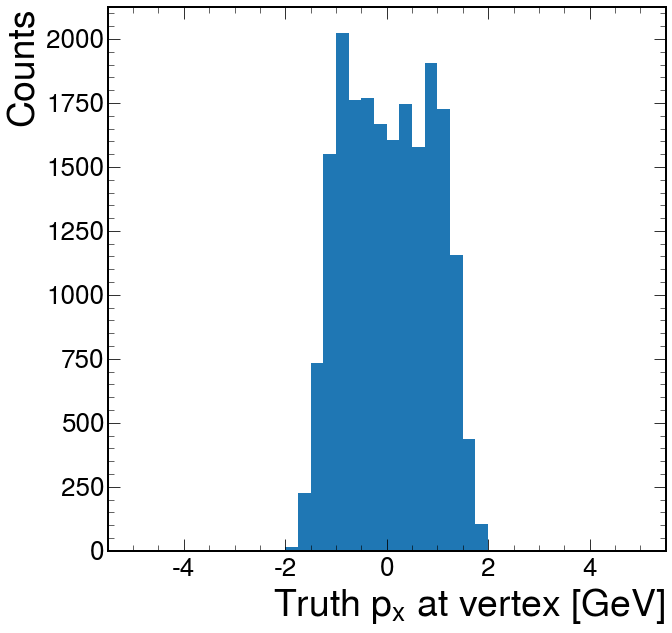

In [44]:
plt.hist(ak.flatten(dq_events["GenVertex"].px),
         bins=40, range=(-5,5), density=False)
plt.xlabel(r"Truth $p_x$ at vertex [GeV]")
plt.ylabel("Counts")

Text(0, 1, 'Counts')

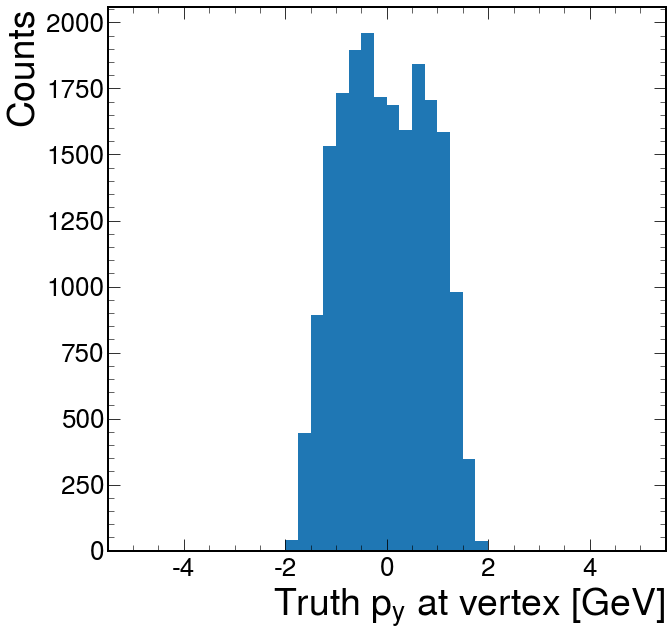

In [45]:
plt.hist(ak.flatten(dq_events["GenVertex"].py),
         bins=40, range=(-5,5), density=False)
plt.xlabel(r"Truth $p_y$ at vertex [GeV]")
plt.ylabel("Counts")

Text(0, 1, 'Counts')

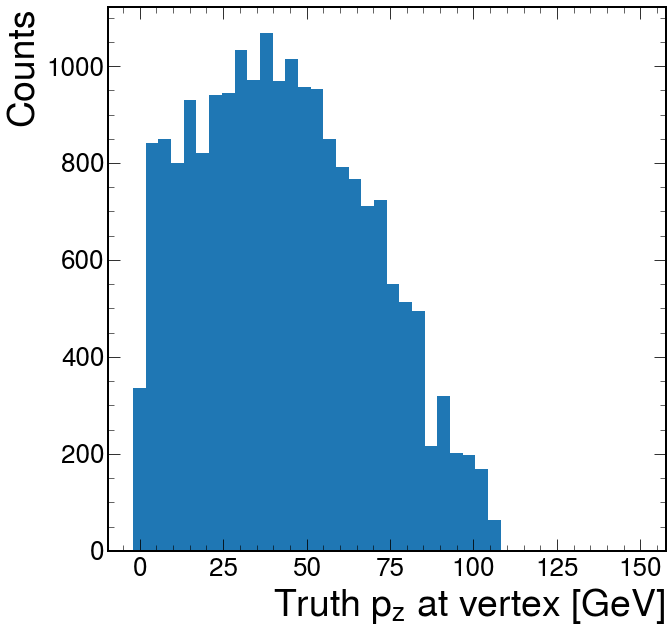

In [50]:
plt.hist(ak.flatten(dq_events["GenVertex"].pz),
         bins=40, range=(-2,150), density=False)
plt.xlabel(r"Truth $p_z$ at vertex [GeV]")
plt.ylabel("Counts")

## Truth momentum at vertex and first station

Text(0, 1, 'Counts')

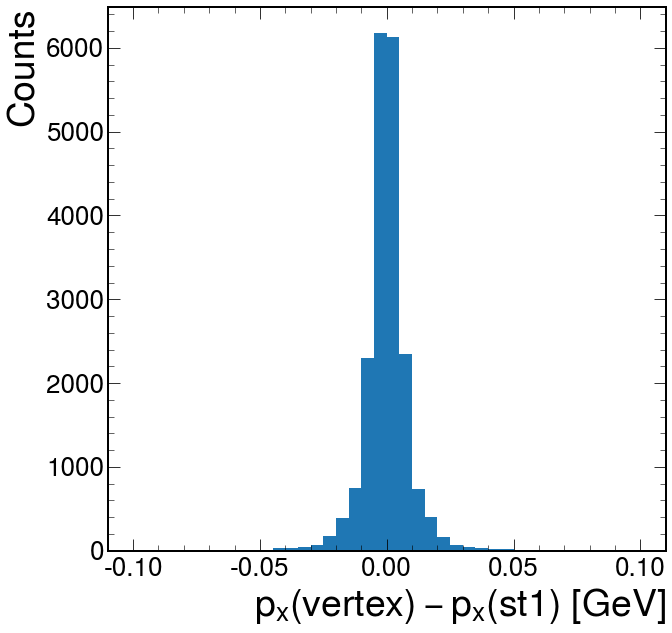

In [30]:
plt.hist(ak.flatten(dq_events["GenVertex"]["px"]- dq_events["GenP_St1"]["px"]),
         bins=40, range=(-0.1,0.1), density=False)
plt.xlabel(r"$p_x(vertex) - p_x(st1)$ [GeV]")
plt.ylabel("Counts")

Text(0, 1, 'Counts')

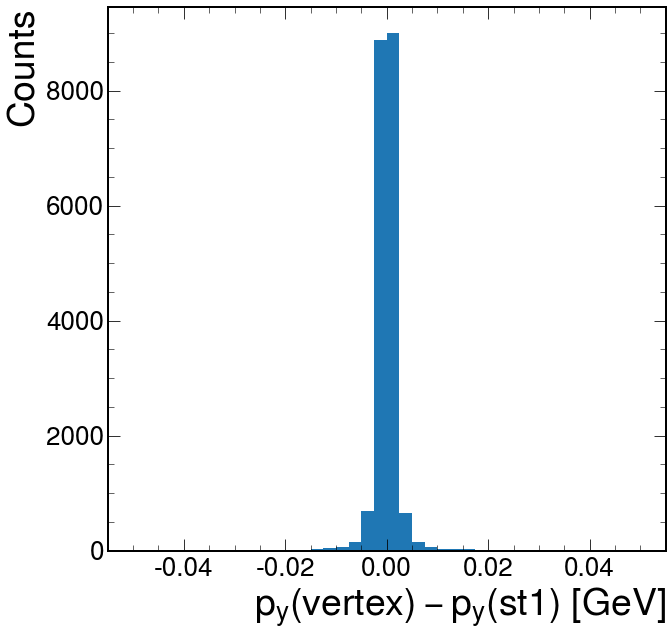

In [34]:
plt.hist(ak.flatten(dq_events["GenVertex"]["py"]- dq_events["GenP_St1"]["py"]),
         bins=40, range=(-0.05,0.05), density=False)
plt.xlabel(r"$p_y(vertex) - p_y(st1)$ [GeV]")
plt.ylabel("Counts")

Text(0, 1, 'Counts')

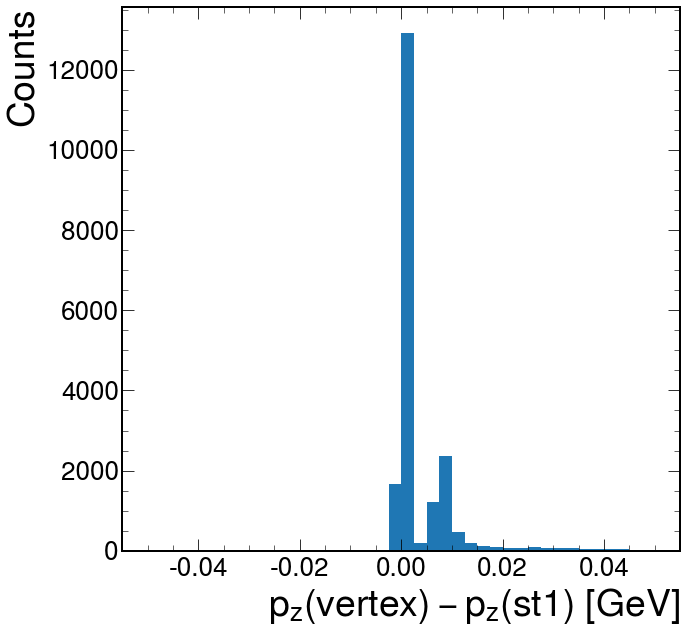

In [33]:
plt.hist(ak.flatten(dq_events["GenVertex"]["pz"]- dq_events["GenP_St1"]["pz"]),
         bins=40, range=(-0.05,0.05), density=False)
plt.xlabel(r"$p_z(vertex) - p_z(st1)$ [GeV]")
plt.ylabel("Counts")

## Comparing truth and track reco info at Station 1

In [35]:
def st1_processor(dq_events):
    
    GenMuons = dq_events['GenP_St1']
    RecoMuons = dq_events["Track_St1"]
    
    events_selected = ak.any(RecoMuons.pz, axis=1)
    RecoMuons_selected = RecoMuons[events_selected]
    GenMuons_selected = GenMuons[events_selected]
    
    # take the max so that no need to do matching
    # not always correct, but should work at leading order
    RecoMuons_selected_pz_max = ak.max(RecoMuons_selected.pz, axis=1)
    GenMuons_selected_pz_max = ak.max(GenMuons_selected.pz, axis=1)
    RecoMuons_selected_px_max = ak.max(RecoMuons_selected.px, axis=1)
    GenMuons_selected_px_max = ak.max(GenMuons_selected.px, axis=1)
    RecoMuons_selected_py_max = ak.max(RecoMuons_selected.py, axis=1)
    GenMuons_selected_py_max = ak.max(GenMuons_selected.py, axis=1)
    
    #Select the max momentum events
    
    ###### X ########
    RecoX_selection = RecoMuons_selected.px >= ak.max(RecoMuons_selected.px, axis=1)[:,None]
    GenX_selection = GenMuons_selected.px >= ak.max(GenMuons_selected.px, axis=1)[:,None]
    
    RecoMuons_selected_x = copy.deepcopy(RecoMuons_selected[RecoX_selection].x)
    GenMuons_selected_x = copy.deepcopy(GenMuons_selected[GenX_selection].x)
    
    fig = plt.figure(figsize=(10,8))
    plt.hist(RecoMuons_selected_x-GenMuons_selected_x, bins=40, range=(-10,10), density=False)
    plt.xlabel(r"$x_{reco} - x_{truth}$ [cm]")
    plt.ylabel('Counts')
    plt.show()
    
    ###### Y ########
    RecoX_selection = RecoMuons_selected.py >= ak.max(RecoMuons_selected.py, axis=1)[:,None]
    GenX_selection = GenMuons_selected.py >= ak.max(GenMuons_selected.py, axis=1)[:,None]
    
    RecoMuons_selected_y = copy.deepcopy(RecoMuons_selected[RecoX_selection].y)
    GenMuons_selected_y = copy.deepcopy(GenMuons_selected[GenX_selection].y)
    
    fig = plt.figure(figsize=(10,8))
    plt.hist(RecoMuons_selected_y-GenMuons_selected_y, bins=40, range=(-10,10), density=False)
    plt.xlabel(r"$y_{reco} - y_{truth}$ [cm]")
    plt.ylabel('Counts')
    plt.show()
    
    ###### Z ########
    RecoX_selection = RecoMuons_selected.pz >= ak.max(RecoMuons_selected.pz, axis=1)[:,None]
    GenX_selection = GenMuons_selected.pz >= ak.max(GenMuons_selected.pz, axis=1)[:,None]
    
    
    RecoMuons_selected_z = copy.deepcopy(RecoMuons_selected[RecoX_selection].z)
    GenMuons_selected_z = copy.deepcopy(GenMuons_selected[GenX_selection].z)
    
    print(GenMuons_selected_z)
    
    fig = plt.figure(figsize=(10,8))
    plt.hist(RecoMuons_selected_z-GenMuons_selected_z, bins=40, range=(-30,30), density=False)
    plt.xlabel(r"$z_{reco} - z_{truth}$ [cm]")
    plt.ylabel('Counts')
    plt.show()
    #plt.savefig("plots/Muon_DeltaPz.png")
    
    #####----------PLOT THEM
    fig = plt.figure(figsize=(10,8))
    #n, bins, patches = plt.hist(RecoMuons_selected_pz_max-GenMuons_selected_pz_max, 60, normed=1, facecolor='green', alpha=0.75)
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=2)
    plt.hist(RecoMuons_selected_pz_max-GenMuons_selected_pz_max, bins=40, range=(-3,3), density=False)
    #plt.xlim(0,40)
    plt.xlabel("$\mu$ $\Delta p_z$ [GeV]")
    plt.ylabel('Counts')
    plt.show()
    #plt.savefig("plots/Muon_DeltaPz.png")

    fig = plt.figure(figsize=(10,8))
    #n, bins, patches = plt.hist(RecoMuons_selected_pz_max-GenMuons_selected_pz_max, 60, normed=1, facecolor='green', alpha=0.75)
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=2)
    plt.hist(RecoMuons_selected_py_max-GenMuons_selected_py_max, bins=40, range=(-0.05,0.05), density=False)
    #plt.xlim(0,40)
    plt.xlabel("$\mu$ $\Delta p_y$ [GeV]")
    plt.ylabel('Counts')
    plt.show()
    #plt.savefig("plots/Muon_DeltaPy.png")

    fig = plt.figure(figsize=(10,8))
    #n, bins, patches = plt.hist(RecoMuons_selected_pz_max-GenMuons_selected_pz_max, 60, normed=1, facecolor='green', alpha=0.75)
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=2)
    plt.hist(RecoMuons_selected_px_max-GenMuons_selected_px_max, bins=40, range=(-0.05,0.05), density=False)
    #plt.xlim(0,40)
    plt.xlabel("$\mu$ $\Delta p_x$ [GeV]")
    plt.ylabel('Counts')
    plt.show()
    #plt.savefig("plots/Muon_DeltaPx.png")

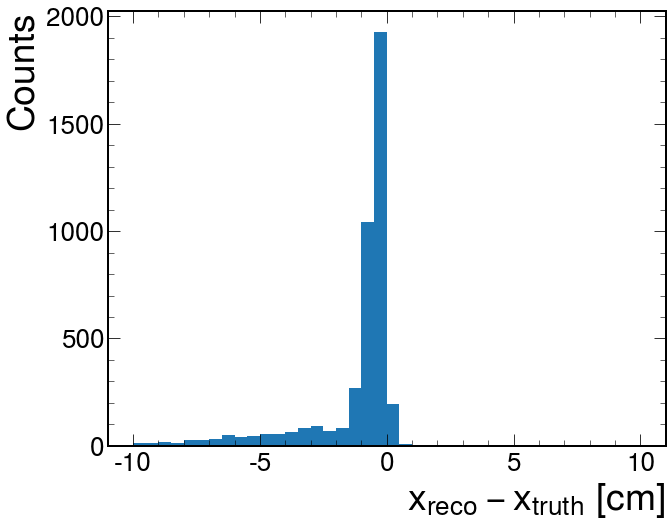

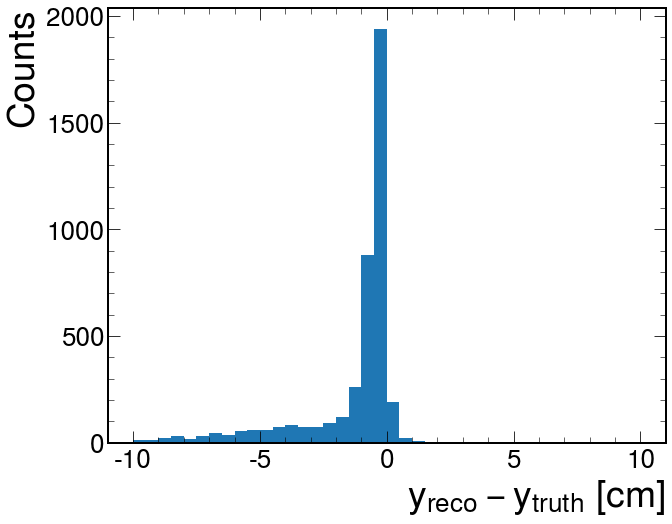

[[617], [617], [617], [617], [617], [617, ... [617], [617], [617], [617], [617]]


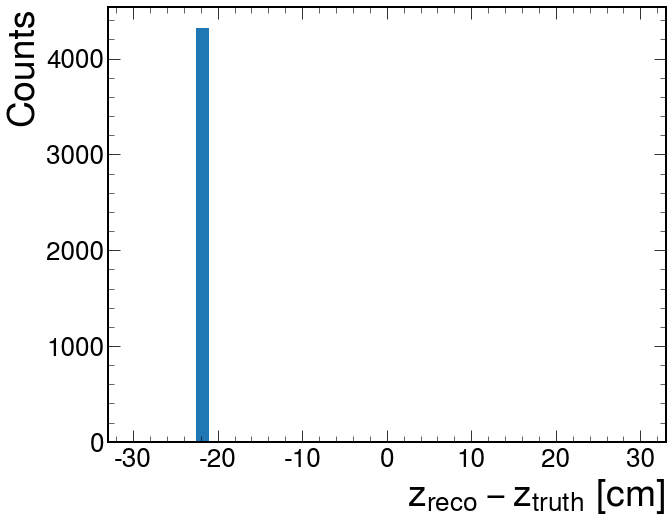

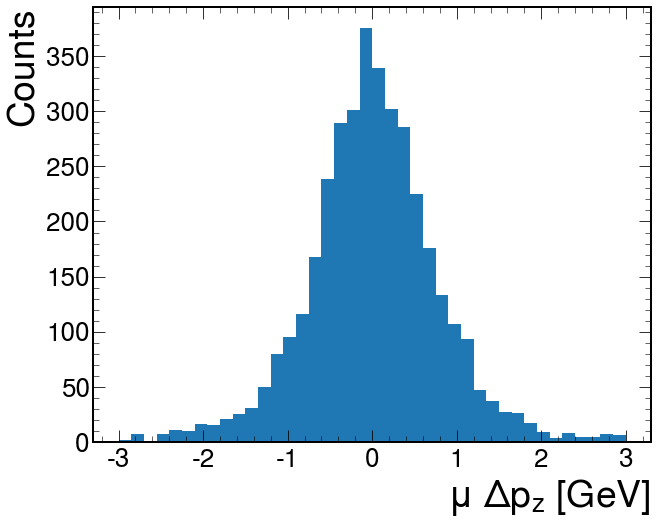

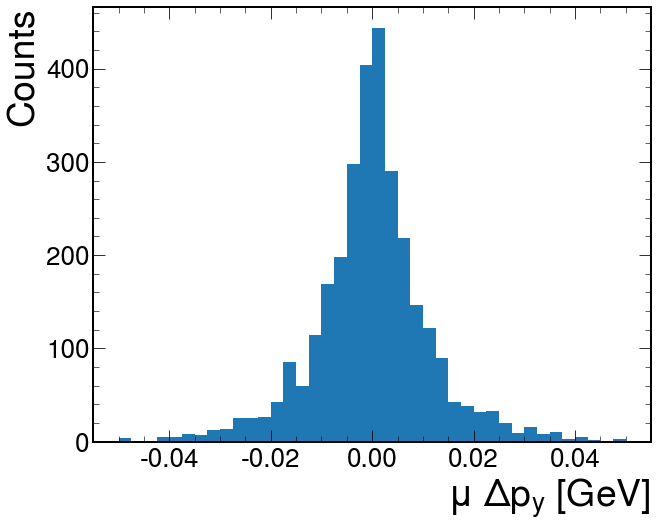

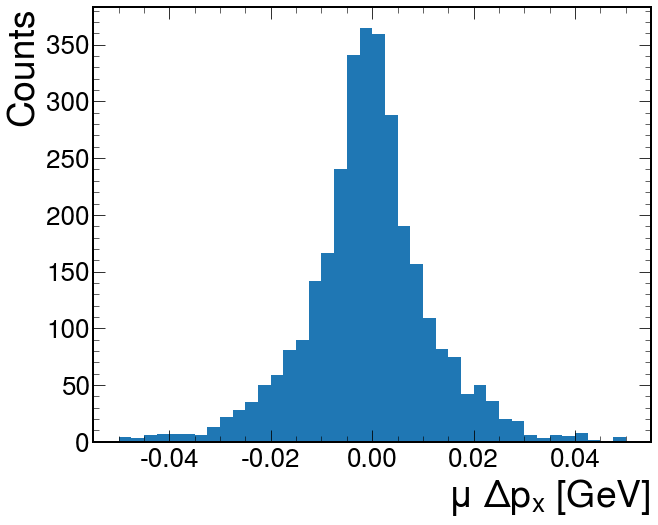

In [36]:
st1_processor(dq_events)

In [6]:
for i in range(100):
    print(track_st1_px[i]) 

[0.106]
[-1.43, 1.09]
[0.674]
[-1.16]
[0.999]
[0.013]
[1.36, -1.06]
[-1.03]
[-1.26, 1.45]
[-0.875]
[1.73, -0.789]
[0.776, -0.358]
[1.46]
[1.11]
[-0.342, 0.4]
[0.297, -0.381]
[0.103]
[1.04]
[-0.934, 0.562]
[0.42]
[0.984]
[1.13, -0.438]
[-0.909]
[0.867, -0.576]
[1.28, -1.01]
[-0.104]
[0.399, -0.129]
[0.196]
[0.181]
[0.718]
[-1.22, 1.11]
[0.375, -0.55]
[-0.0281]
[1.29, -1.15]
[0.745]
[0.0977]
[-0.985, 1.35]
[0.531]
[0.759]
[-0.526]
[-0.459]
[0.727, -0.598]
[-0.00639, 0.0651]
[-0.177]
[-0.604]
[0.342]
[-0.567]
[-0.938]
[0.421, -0.709]
[0.279]
[1.57]
[-1.06]
[0.299]
[-0.516, 1.06]
[0.695]
[-0.691]
[-0.632]
[-0.788]
[-0.56]
[0.952, -1.16]
[1.05, -1.06]
[0.426, -1.11]
[0.616, -0.537]
[1.29, -0.979]
[0.294, 0.113]
[-1.77, 1.06]
[-0.825]
[1.32, -0.899]
[1.15, -0.705]
[-0.102]
[1.33, -1.1]
[-0.563]
[0.635]
[0.823]
[-0.958]
[-0.816]
[-0.564, 0.471]
[-0.286, 0.351]
[1.44, -0.834]
[0.106]
[-0.856, 0.758]
[-0.712]
[0.851, -0.577]
[-1.12, 1.5]
[0.879]
[-0.682, 0.955]
[-0.293, -0.301]
[0.226]
[-1, 0.2

In [7]:
for i in range(100):
    print(truth_st1_px[i]) 

[-0.027, 0.107]
[-1.43, 1.07]
[-1.19, 0.675]
[-1.16, 1.22]
[-0.807, 1]
[0.0173, -0.0966]
[-1.08, 1.35]
[-1.02, 0.517]
[-1.27, 1.46]
[-0.867, 0.503]
[-0.818, 1.74]
[-0.355, 0.773]
[-0.935, 1.47]
[-0.796, 1.1]
[-0.341, 0.422]
[-0.385, 0.3]
[0.0655, 0.102]
[-0.606, 1.05]
[-0.932, 0.569]
[0.0139, 0.418]
[-0.913, 0.987]
[-0.445, 1.12]
[-0.909, 0.763]
[-0.584, 0.851]
[-1.03, 1.3]
[-0.105, 0.66]
[-0.132, 0.399]
[-0.546, 0.209]
[-1.01, 0.181]
[-0.459, 0.723]
[-1.2, 1.09]
[-0.558, 0.372]
[-0.0294, 0.717]
[-1.14, 1.26]
[-0.3, 0.746]
[0.101, -0.178]
[-0.974, 1.34]
[-0.405, 0.536]
[-1.05, 0.756]
[-0.52, 1.39]
[-0.457, -0.323]
[-0.561, 0.73]
[0.0666, -0.00218]
[-0.176, 0.376]
[-0.582, 1.37]
[-0.0699, 0.343]
[-0.568, 0.354]
[-0.94, 0.935]
[-0.711, 0.422]
[-0.574, 0.275]
[-1.18, 1.58]
[-1.07, 1.3]
[0.052, 0.297]
[-0.522, 1.05]
[-0.728, 0.696]
[-0.689, 0.855]
[-0.626, 0.894]
[-0.813, 0.63]
[-0.569, 0.324]
[-1.17, 0.951]
[-1.07, 1.07]
[-1.12, 0.432]
[-0.535, 0.632]
[-0.971, 1.23]
[0.297, 0.122]
[-1.78,

In [3]:
track_st1_px = dq_events["Track_St1"]["px"][ak.num(dq_events["Track_St1"]["px"]) != 0]
truth_st1_px = dq_events["GenP_St1"]["px"][ak.num(dq_events["Track_St1"]["px"]) != 0]
plt.hist(truth_st1_px- track_st1_px,
         bins=40, range=(-5,5), density=False)
plt.xlabel(r"$p_x(vertex) - p_x(st1)$ [GeV]")
plt.ylabel("Counts")

ValueError: in ListArray64, cannot broadcast nested list

(https://github.com/scikit-hep/awkward-1.0/blob/1.2.0/src/cpu-kernels/awkward_ListArray_broadcast_tooffsets.cpp#L27)

## Comparing vertex position and station 1 hit

Text(0, 1, 'Counts')

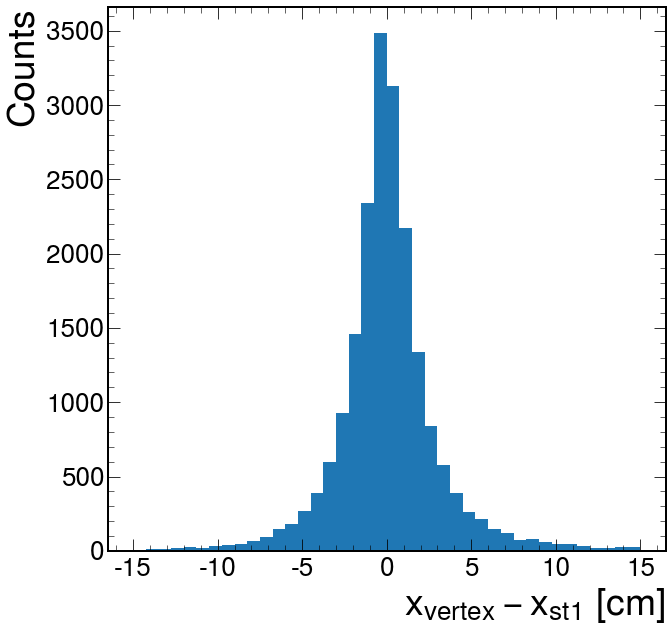

In [9]:
plt.hist(ak.flatten(dq_events["GenVertex"]["vx"] - dq_events["GenP_St1"]["hit_x"]),
         bins=40, range=(-15,15), density=False)
plt.xlabel(r"$x_{vertex} - x_{st1}$ [cm]")
plt.ylabel("Counts")

Text(0, 1, 'Counts')

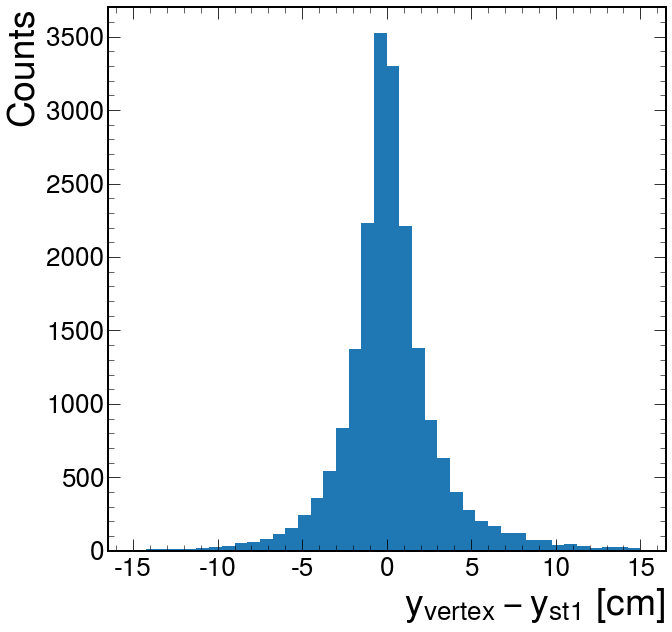

In [10]:
plt.hist(ak.flatten(dq_events["GenVertex"]["vy"] - dq_events["GenP_St1"]["hit_y"]),
         bins=40, range=(-15,15), density=False)
plt.xlabel(r"$y_{vertex} - y_{st1}$ [cm]")
plt.ylabel("Counts")

Text(0, 1, 'Counts')

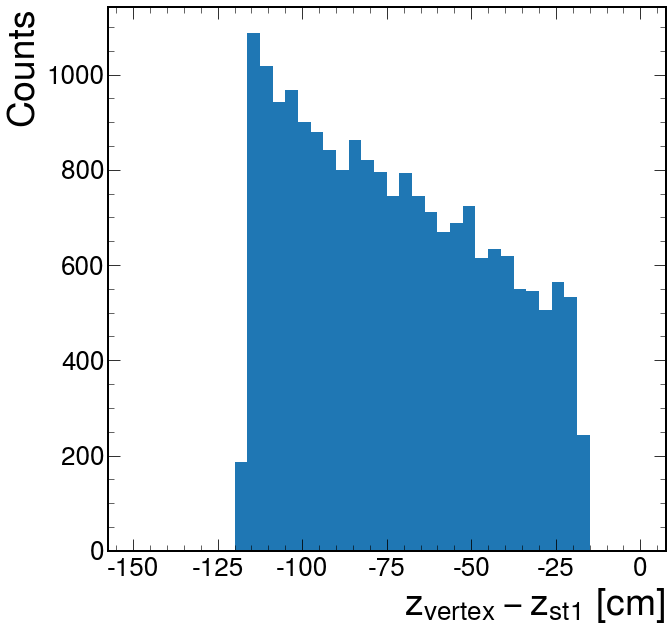

In [14]:
plt.hist(ak.flatten(dq_events["GenVertex"]["vz"] - dq_events["GenP_St1"]["hit_z"]),
         bins=40, range=(-150,0), density=False)
plt.xlabel(r"$z_{vertex} - z_{st1}$ [cm]")
plt.ylabel("Counts")

## Ratio of change in position and px

In [2]:
hists = {}
hists["x_z"] = hist.Hist("Events",
                             hist.Bin("x", r"$x_{vertex}$ [cm]", 40, 0, 20),
                             hist.Bin("z", r"$z_{vertex}$ [cm]" , 40, 500, 600))

hists["y_z"] = hist.Hist("Events",
                             hist.Bin("y",  r"$y_{vertex}$ [cm]" , 40, 0, 20),
                             hist.Bin("z", r"$z_{vertex}$ [cm]" , 40, 500, 600))
hists["x_y"] = hist.Hist("Events",
                             hist.Bin("x", r"$x_{vertex}$ [cm]", 40, 0, 20),
                             hist.Bin("y",  r"$y_{vertex}$ [cm]" , 40, 0, 20))

hists["x_ratio"] = hist.Hist("Events",
                             hist.Bin("x_residual", r"$x_{st1} - x_{vertex}$ [cm]", 40, 0, 20),
                             hist.Bin("px", r"Truth Vertex $p_x$ [GeV]" , 40, 0, 3))
hists["y_ratio"] = hist.Hist("Events",
                             hist.Bin("y_residual", r"$y_{st1} - y_{vertex}$ [cm]", 40, 0, 20),
                             hist.Bin("py", r"Truth Vertex $p_y$ [GeV]" , 40, 0, 3))
hists["z_ratio"] = hist.Hist("Events",
                             hist.Bin("z_residual", r"$z_{st1} - z_{vertex}$ [cm]", 40, 0, 150),
                             hist.Bin("pz", r"Truth Vertex $p_z$ [GeV]" , 40, 0, 150))

def ratio_processor(dq_events):
    
    
    #Select the event
    truth_vertex = dq_events["GenVertex"]
    truth_station_hit = dq_events["GenP_St1"]
    
    #Define
    hists["x_ratio"].fill(x_residual = ak.flatten(truth_station_hit.x - truth_vertex.x),
                         px = ak.flatten(truth_vertex.px))
    hists["y_ratio"].fill(y_residual = ak.flatten(truth_station_hit.y - truth_vertex.y),
                         py = ak.flatten(truth_vertex.py))
    hists["z_ratio"].fill(z_residual = ak.flatten(truth_station_hit.z - truth_vertex.z),
                         pz = ak.flatten(truth_vertex.pz))
    
    hists["x_z"].fill(x = ak.flatten(truth_vertex.x), z = ak.flatten(truth_vertex.z))
    hists["y_z"].fill(y = ak.flatten(truth_vertex.y), z = ak.flatten(truth_vertex.z))
    hists["x_y"].fill(x = ak.flatten(truth_vertex.x), y = ak.flatten(truth_vertex.y))

In [3]:
ratio_processor(dq_events)

/seaquest/users/dhoang/miniconda3/envs/Dimuon/lib/python3.8/site-packages/coffea/hist/hist_tools.py:507: RuntimeWarning: overflow encountered in multiply
  idx = numpy.clip(numpy.floor((identifier - self._lo) * float(self._bins) / (self._hi - self._lo)) + 1, 0, self._bins + 1)


<AxesSubplot:xlabel='$x_{st1} - x_{vertex}$ [cm]', ylabel='Truth Vertex $p_x$ [GeV]'>

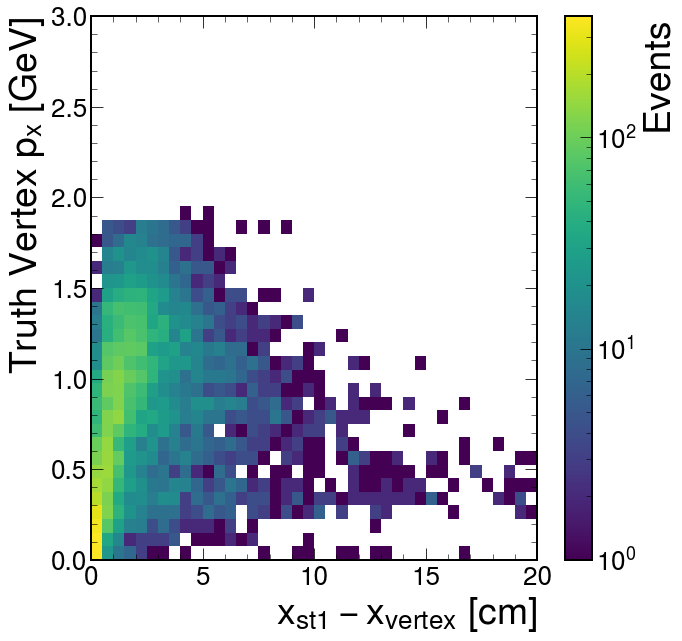

In [4]:
hist.plot2d(hists["x_ratio"], xaxis = 'x_residual', patch_opts={'norm':colors.LogNorm()})

<AxesSubplot:xlabel='$y_{st1} - y_{vertex}$ [cm]', ylabel='Truth Vertex $p_y$ [GeV]'>

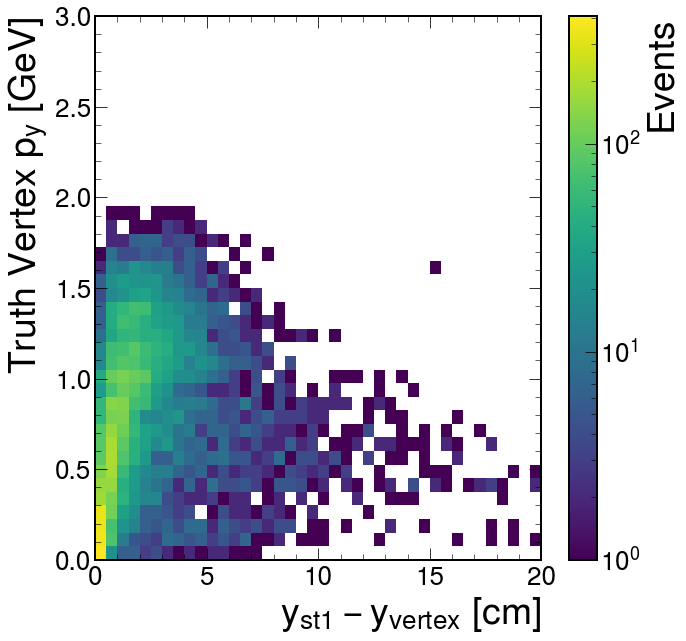

In [5]:
hist.plot2d(hists["y_ratio"], xaxis = 'y_residual', patch_opts={'norm':colors.LogNorm()})

<AxesSubplot:xlabel='$z_{st1} - z_{vertex}$ [cm]', ylabel='Truth Vertex $p_z$ [GeV]'>

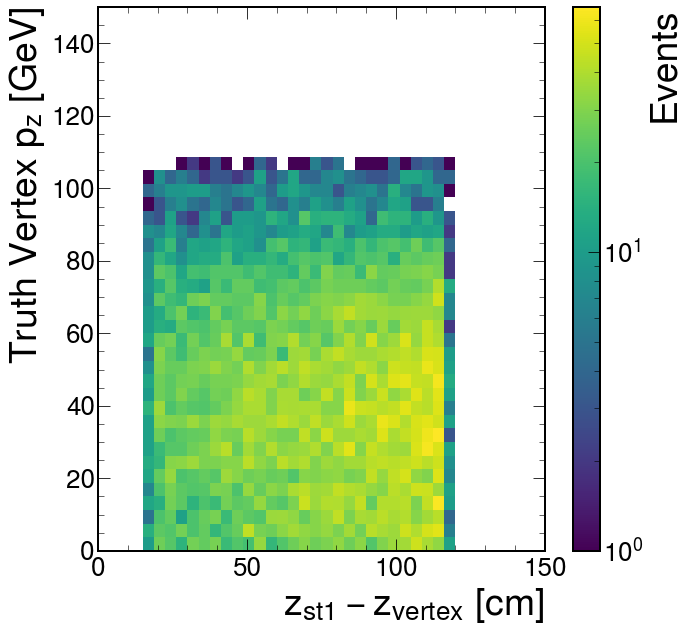

In [6]:
hist.plot2d(hists["z_ratio"], xaxis = 'z_residual', patch_opts={'norm':colors.LogNorm()})

<AxesSubplot:xlabel='$z_{vertex}$ [cm]', ylabel='$x_{vertex}$ [cm]'>

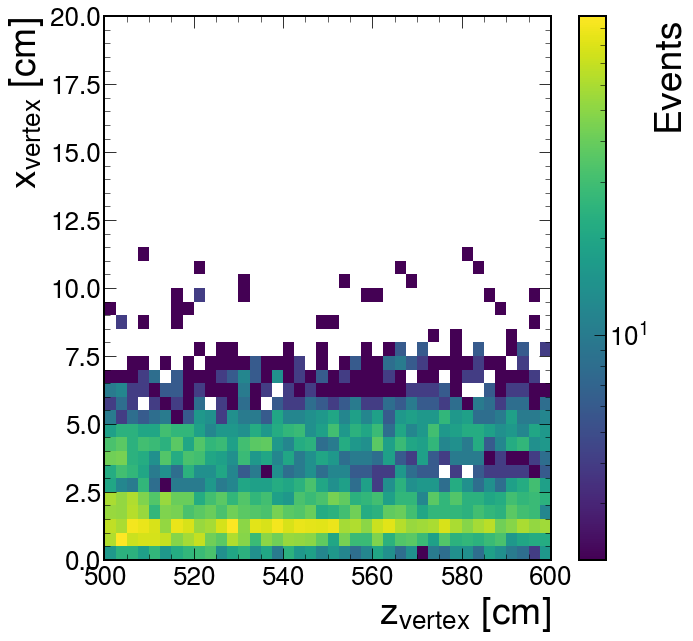

In [4]:
hist.plot2d(hists["x_z"], xaxis = "z", patch_opts={'norm':colors.LogNorm()})

<AxesSubplot:xlabel='$z_{vertex}$ [cm]', ylabel='$y_{vertex}$ [cm]'>

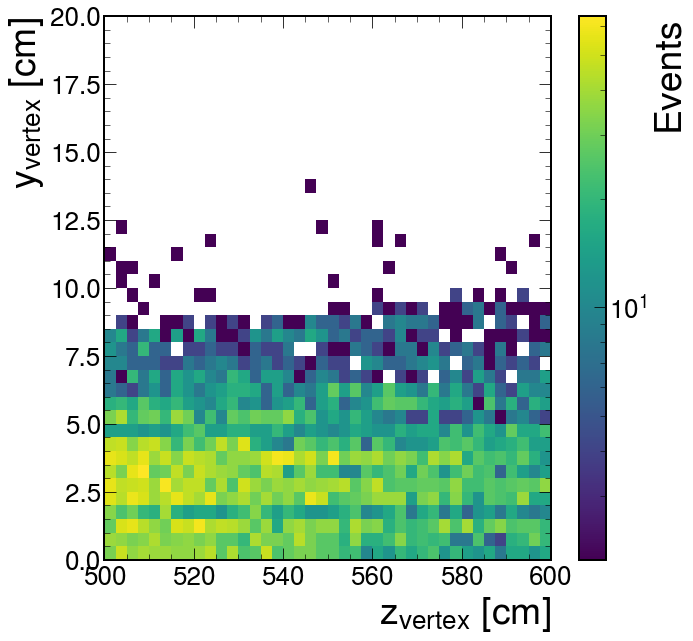

In [6]:
hist.plot2d(hists["y_z"], xaxis = "z", patch_opts={'norm':colors.LogNorm()})

<AxesSubplot:xlabel='$x_{vertex}$ [cm]', ylabel='$y_{vertex}$ [cm]'>

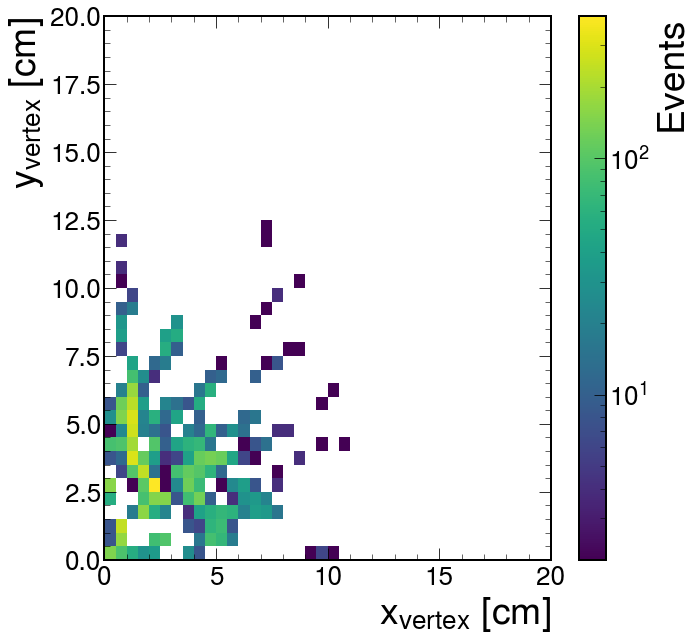

In [8]:
hist.plot2d(hists["x_y"], xaxis = "x", patch_opts={'norm':colors.LogNorm()})

## 2. Reco-ed track position at station1

## 3. Truth track momentum at station1

## 4. Truth track hits at station1

## 5. Truth track momentum at the vertex (i.e., where A’ decays)

should be pretty similar (or almost the same as) the truth track momentum at station1.

## 6.  Truth vertex position, i.e., where A’ decays. (Our target for the displaced vtx reconstruction.)